# Gaussian Processes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics
import scipy
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

C:\Users\User\anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
# Create training data
x_train = np.array([-4, -3, -2, -1, 1]).reshape(5,1)
noise = 0.2
# y takes Sinusoidal values
y_train = np.sin(x_train) # + np.random.normal(0, noise, size=(5,1))
# Number of training points
n_t = len(x_train)  

In [3]:
# Test data (what we want to estimate/interpolate)
n_s = 50
x_test = np.linspace(-5, 5, n_s).reshape(-1,1)

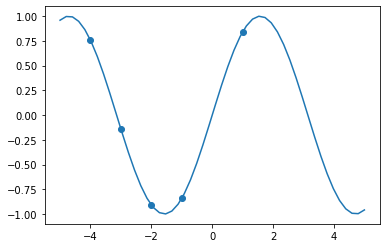

In [4]:
plt.scatter(x_train, y_train)
plt.plot(x_test, np.sin(x_test))

# Kernel-First View

$$ k(x, x') = \sigma_{f} exp(-\frac{1}{2 l^2} \|x - x'\|^2) $$
where $$ \sigma_{f} ~\text{and}~ l$$ are Hyperparameters

In [51]:
def kernel(x1, x2, l=1, sig_var=1):
    distance = sklearn.metrics.pairwise_distances(x1,x2)
    k = sig_var*np.exp(-1/(2*l**2)*distance**2)
    return k


Prio

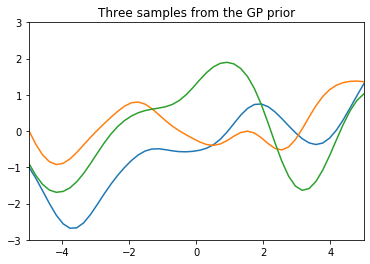

In [9]:
k_ss = kernel(x_test, x_test)  # kernel between test points
# we have n_s=50 smaple points, hence its is 50 dimensional,
# we draw 3 gaussian function
size_f=3
f_prior = np.random.multivariate_normal(mean=np.zeros(n_s), cov=k_ss, size=size_f).T

# Now lets plot the 3 smapled functions
plt.plot(x_test, f_prior)
plt.axis([-5, 5, -3, 3])
plt.title('Three samples from the GP prior')
plt.show()

# Predictions with GP's

$$ \text{The joint distribution of test points} ~ f^{*} (\text{at} X^{*} )~ \text{and} ~\text{training points} f(X))$$

In [15]:
# Applying the kernel function to our training points 
k = kernel(x_train, x_train)  # kernel between the traing points
noise = 0
k_inv = np.linalg.inv(k + noise*np.eye(n_t))
# and to our mutual
k_s = kernel(x_train, x_test)  # kernel bewteen taring and text points
# Compution of mean
mu = k_s.T@k_inv@y_train.squeeze()
# computing covarinace matrix, and corresponding stdv 
cov = k_ss - k_s.T@k_inv@k_s
stdv = np.sqrt(np.diag(cov)).squeeze()

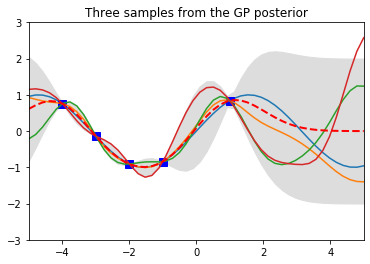

In [19]:
# draw smaples from the posterior at our test points
f_post = np.random.multivariate_normal(mean=mu, cov=cov, size=size_f).T

# plot 
plt.plot(x_test, np.sin(x_test))
plt.plot(x_train, y_train, 'bs', ms=8)
plt.plot(x_test, f_post)
plt.gca().fill_between(x_test.flat, mu-2*stdv, mu+2*stdv, color="#dddddd")
plt.plot(x_test, mu, 'r--', linewidth=2.0)
plt.axis([-5, 5, -3, 3])
plt.title('Three samples from the GP posterior')
plt.show()

For numerical reasons, since k is always Symmetric and usually
Positive definite, Cholesky decomposition is better.
$$ k = LL^{T}$$
$$ kx=y \rightarrow LL^{T}x=y \rightarrow Lu=y, ~ \text{where}~
L^{T}x=u$$

In [20]:
# Cholesky Decomposition (instead of inverting the (k = sigma matrix))
L = np.linalg.cholesky(k + noise*np.eye(n_t))
alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_train))
mu = (k_s.T@alpha).squeeze()
v = np.linalg.solve(L, k_s)
cov = k_ss - v.T@v

In [52]:
def GP(x_train, y_train, x_test, l, sig_var=1, noise_var=0):
    k_ss = kernel(x_test, x_test, l, sig_var)
    k = kernel(x_train, x_train, l, sig_var)
    
    L = np.linalg.cholesky(k + noise_var*np.eye(n_t))
    k_s = kernel(x_train, x_test, l, sig_var)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_train))
    mu = (k_s.T@alpha).squeeze()
    v = np.linalg.solve(L, k_s)
    cov = k_ss - v.T@v
    stdv = stdv = np.sqrt(np.diag(cov)).squeeze()
    
    #Plot
    plt.figure(figsize=(10,8))
    #plt.plot(x_test, np.sin(x_test))
    plt.plot(x_train, y_train, 'bs', ms=8)
    #plt.plot(x_test, f_post)
    plt.gca().fill_between(x_test.flat, mu-2*stdv, mu+2*stdv, color="#dddddd")
    plt.plot(x_test, mu, 'r--', linewidth=2.0)
    plt.axis([-5, 5, -3, 3])
    plt.title('Three samples from the GP posterior')
    plt.show()
    

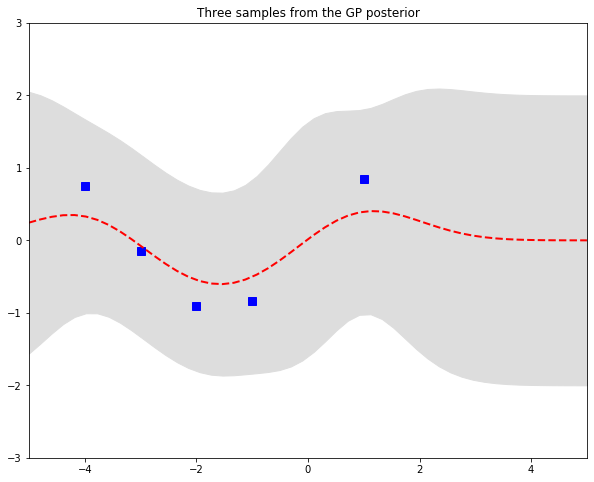

In [55]:
GP(x_train, y_train, x_test, 1, 1, 1)